In [1]:
import numpy as np
import pandas as pd
from os import path as osp
import os
from matplotlib import pyplot as plt
import lightgbm as lgb

from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, fbeta_score, mean_absolute_percentage_error
import utils

import pickle
def save_obj(obj, name):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(name + '.pickle', 'rb') as f:
        return pickle.load(f)

In [2]:
import warnings

# 禁用FutureWarning警告
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
DATA_PATH = '/data'
MODEL_PAHT = '/work/model'
SEED = 2222
if not os.path.exists(MODEL_PAHT):
    os.mkdir(MODEL_PAHT)
    
data_type='train'

In [4]:
def q1(x):
    return x.quantile(0.1)
def q2(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.7)
def q4(x):
    return x.quantile(0.9)
def mode_max(x):
    return x.mode().max()
def mode_min(x):
    return x.mode().min()
def mode_mean(x):
    return x.mode().mean()
def mode_std(x):
    return x.mode().std()
def mode_len(x):
    return x.mode().shape[0]
def mode_times(x):
    return x.value_counts().iloc[0]

In [5]:
def get_data(data_type='train'):
    train_base = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_base.csv'))
    train_base = train_base.sort_values(['cust_wid']).reset_index(drop=True)
    train_view = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_view.csv'), encoding='gbk')
    train_trx = pd.read_csv(osp.join(DATA_PATH, f'{data_type}_trx.csv'))

    # deal base gdr_cd
    train_base['gdr_cd'] = train_base['gdr_cd'].map({'M':1, 'F':2})
    train_base['gdr_cd'] = train_base['gdr_cd'].fillna(0)

    # deal base cty_cd
    train_base['cty_cd'] = train_base['cty_cd'].str.slice(stop=2)
    train_base.cty_cd = train_base.cty_cd.fillna('NAN')
    cty_map = ['C', '44', '11', 'A', '31', '32', '37', '21', '42', '61', 'B', '33', '50', '12', '35', '36', '51', '43', '62', '53', '34', '23', '65', '41', 'NAN']
    cty_map = dict(zip(cty_map, range(1,len(cty_map)+1)))
    train_base['cty_cd'] = train_base['cty_cd'].map(cty_map).fillna(0)

    # idx = train_view.acs_tm.str.contains('下午')
    train_view.acs_tm = train_view.acs_tm.str.rstrip(':').str.replace('上午|下午', '', regex=True).str.replace('1492', '2022')
    train_view.acs_tm = pd.to_datetime(train_view.acs_tm)
    train_view['day'] = train_view.acs_tm.dt.day

    train_trx.trx_tm = train_trx.trx_tm.str.replace('1492', '2022')
    train_trx.trx_tm = pd.to_datetime(train_trx.trx_tm)
    train_trx['day'] = train_trx.trx_tm.dt.day

    train_view['day_diff'] = train_view['day'].max() - train_view['day']
    train_trx['day_diff'] = train_trx['day'].max() - train_trx['day']

    if data_type=='train':
        train_view['day'] -= 4
        train_trx['day'] -= 4
    elif data_type=='testa':
        train_view['day'] -= 3
        train_trx['day'] -= 3

    print(train_trx['day'].max(), train_trx['day'].min())

    train_view['ntimes'] = train_view['day']//14
    train_trx['ntimes'] = train_trx['day']//14
    train_view['day'] %= 14
    train_trx['day'] %= 14

#     train_idx = pd.Index(train_base['cust_wid'], name='cust_wid')
#     tmp_idx = train_view['acs_tm'].isna()
#     train_view_nan = pd.DataFrame({'cust_wid': train_view[tmp_idx]['cust_wid'].unique(), 'view_nan': 1}).set_index('cust_wid').reindex(train_idx).fillna(0).reset_index(drop=True)

#     tmp_idx = train_trx['trx_tm'].isna()
#     train_trx_nan = pd.DataFrame({'cust_wid': train_trx[tmp_idx]['cust_wid'].unique(), 'trx_nan': 1}).set_index('cust_wid').reindex(train_idx).fillna(0).reset_index(drop=True)

#     train_base = pd.concat([train_base, train_view_nan, train_trx_nan], axis=1)



    train_view = train_view.query('day>=0').reset_index(drop=True)
    train_trx = train_trx.query('day>=0').reset_index(drop=True)


    train_view['day'] = train_view['day'].astype('int')
    train_trx['day'] = train_trx['day'].astype('int')

    train_view = train_view.sort_values(['cust_wid','acs_tm']).reset_index(drop=True)
    train_trx = train_trx.sort_values(['cust_wid','trx_tm']).reset_index(drop=True)

    page_id_enc = load_obj(osp.join(MODEL_PAHT, 'page_id_enc'))
    trx_id_enc = load_obj(osp.join(MODEL_PAHT, 'trx_id_enc'))

    train_view['page_enc'] = train_view['page_id'].map(page_id_enc)
    train_view['page_enc'] = train_view['page_enc'].fillna(page_id_enc['NAN'])
    train_trx['trx_enc'] = train_trx['trx_cd'].map(trx_id_enc)

    train_view['acs_tm_diff'] = train_view.groupby('cust_wid')['acs_tm'].diff().dt.total_seconds()
    train_trx['trx_tm_diff'] = train_trx.groupby('cust_wid')['trx_tm'].diff().dt.total_seconds()
    train_view['daytime'] = train_view['acs_tm'].dt.time.apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    train_trx['daytime'] = train_trx['trx_tm'].dt.time.apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
    train_trx['flag'] = (train_trx['trx_amt'] >0).astype('int')

    train_idx = pd.Index(train_base['cust_wid'], name='cust_wid')

    view_agg_func = {
        'day':['mean', 'min', 'max', 'std', np.ptp, 'nunique'],
        'page_id':['count', 'nunique'], 
        'acs_tm_diff':['mean', 'min', 'max', 'std', 'median', 'sum'], 
        'daytime':['mean', 'min', 'max', 'std', np.ptp],
        'page_enc': [
            'mean', 'min', 'max', 'std', 'median', 'sum', 
            np.ptp, "sem", "mad", "skew", pd.Series.kurtosis, 
            q1, q2, q3, q4, 'last',
            # mode_max, mode_min, mode_mean, mode_std, mode_len, mode_times
        ],
        'day_diff': ['min'],
    }
    train_view_c = train_view.groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    train_view_c.columns = [f'vie_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_c.columns]
    train_base = pd.concat([train_base, train_view_c], axis=1)

    #     train_view_cn1 = train_view.query('ntimes==1').groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_view_cn1.columns = [f'vie_d_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_cn1.columns]

    #     train_view_cn0 = train_view.query('ntimes==0').groupby('cust_wid').agg(view_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_view_cn0.columns = [f'vie_d_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_cn0.columns]

    #     train_view_c = train_view_cn1-train_view_cn0
    #     train_base = pd.concat([train_base, train_view_c], axis=1)

    trx_agg_func = {
        'day':['mean', 'min', 'max', 'std', np.ptp, 'nunique'],
        'trx_cd':['count', 'nunique'], 
        'trx_tm_diff':['mean', 'min', 'max', 'std', 'median', 'sum'], 
        'daytime':['mean', 'min', 'max', 'std', np.ptp], 
        'trx_amt':['mean', 'min', 'max', 'std', 'median', 'sum', np.ptp, 'last'],
        'trx_enc': ['mean', 'min', 'max', 'std', 'median', 'sum', np.ptp, 'last'],
        'day_diff': ['min'],
    }
    train_trx_c = train_trx.groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    train_trx_c.columns = [f'trx_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    train_base = pd.concat([train_base, train_trx_c], axis=1)

    #     train_trx_c = train_trx.query('flag==1').groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_trx_c.columns = [f'trx_1_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    #     train_base = pd.concat([train_base, train_trx_c], axis=1)

    #     train_trx_c = train_trx.query('flag==0').groupby('cust_wid').agg(trx_agg_func).reindex(train_idx).reset_index(drop=True)
    #     train_trx_c.columns = [f'trx_0_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_trx_c.columns]
    #     train_base = pd.concat([train_base, train_trx_c], axis=1)

    train_view['group'] = (train_view['acs_tm_diff']>5*60).cumsum()
    train_view['group'] -= train_view['cust_wid'].map(train_view.groupby('cust_wid').agg({'group':'min'}).to_dict()['group'])
    train_reg_base = pd.DataFrame()

    train_view_group = train_view.groupby(['cust_wid', 'group']).agg({'page_enc': ['mean', 'min', 'max', 'std'], 'page_id':['count', 'nunique'], 'daytime':['mean',]}).reset_index()
    train_view_group.columns = [f'{item[0]}_{item[1]}' if item[0] not in ['cust_wid', 'group'] else item[0] for item in train_view_group.columns]
    train_view_group = train_view_group.groupby(['cust_wid']).agg({
        'group': ['max'],
        'page_enc_mean': ['mean', 'min', 'max', 'std'],
        'page_enc_min': ['mean', 'min', 'max', 'std'],
        'page_enc_max': ['mean', 'min', 'max', 'std'],
        'page_enc_std': ['mean', 'min', 'max', 'std'],
        'page_id_count': ['mean', 'min', 'max', 'std'],
        'page_id_nunique': ['mean', 'min', 'max', 'std'],
        'daytime_mean': ['mean', 'min', 'max', 'std'],
    }).reindex(train_idx).reset_index(drop=True)
    train_view_group.columns = [f'vie_gop_{item[0]}_{item[1]}' if item[0] not in ['cust_wid'] else item[0] for item in train_view_group.columns]
    train_reg_base = pd.concat([train_reg_base,train_view_group], axis=1)
    
    
    train_idx = pd.MultiIndex.from_product([train_base['cust_wid'], range(14)], names=['cust_wid', 'day'])
    train_view_cust = train_view.groupby(['cust_wid', 'day'])['page_id'].agg(['count', 'nunique']).reset_index()
    train_trx_cust = train_trx.groupby(['cust_wid', 'day'])[['trx_cd', 'trx_amt']].agg({'trx_cd':['count', 'nunique'], 'trx_amt':['min', 'max', 'mean', 'std']}).reset_index()
    train_trx_cust.columns = [f'{item[0]}_{item[1]}' if item[0] in ['trx_cd', 'trx_amt'] else item[0] for item in train_trx_cust.columns]

    train_view_cust = train_view_cust.set_index(['cust_wid','day']).reindex(train_idx).reset_index().sort_values(['cust_wid','day']).reset_index(drop=True)
    train_trx_cust = train_trx_cust.set_index(['cust_wid','day']).reindex(train_idx).reset_index().sort_values(['cust_wid','day']).reset_index(drop=True)

    train_view_cust = train_view_cust[[item for item in train_view_cust.columns if item not in ['cust_wid','day']]]
    train_view_cust_cols = train_view_cust.columns
    train_view_cust = train_view_cust.values.reshape(train_base['cust_wid'].shape[0], 14*len(train_view_cust_cols))
    train_view_cust = pd.DataFrame(train_view_cust, columns=[f"view_cust_{item}_{day}" for day in range(14) for item in train_view_cust_cols])

    train_trx_cust = train_trx_cust[[item for item in train_trx_cust.columns if item not in ['cust_wid','day']]]
    train_trx_cust_cols = train_trx_cust.columns
    train_trx_cust = train_trx_cust.values.reshape(train_base['cust_wid'].shape[0], 14*len(train_trx_cust_cols))
    train_trx_cust = pd.DataFrame(train_trx_cust, columns=[f"trx_cust_{item}_{day}" for day in range(14) for item in train_trx_cust_cols])
    train_reg_base = pd.concat([train_reg_base, train_view_cust, train_trx_cust], axis=1)

    return train_base, train_reg_base

In [6]:
# train_view_c = train_view.groupby(['cust_wid', 'day']).agg(view_agg_func)

In [7]:
# 众数

In [8]:
train_base, train_reg_base = get_data(data_type='train')
testA_base, testA_reg_base = get_data(data_type='testa')


27.0 -3.0
27.0 -2.0


In [9]:
FEATS = [item for item in train_base.columns if item not in ['cust_wid', 'label']]
TARGET_COL = 'label'
print(len(FEATS))

75


In [10]:
print(FEATS)

['age', 'gdr_cd', 'cty_cd', 'vie_day_mean', 'vie_day_min', 'vie_day_max', 'vie_day_std', 'vie_day_ptp', 'vie_day_nunique', 'vie_page_id_count', 'vie_page_id_nunique', 'vie_acs_tm_diff_mean', 'vie_acs_tm_diff_min', 'vie_acs_tm_diff_max', 'vie_acs_tm_diff_std', 'vie_acs_tm_diff_median', 'vie_acs_tm_diff_sum', 'vie_daytime_mean', 'vie_daytime_min', 'vie_daytime_max', 'vie_daytime_std', 'vie_daytime_ptp', 'vie_page_enc_mean', 'vie_page_enc_min', 'vie_page_enc_max', 'vie_page_enc_std', 'vie_page_enc_median', 'vie_page_enc_sum', 'vie_page_enc_ptp', 'vie_page_enc_sem', 'vie_page_enc_mad', 'vie_page_enc_skew', 'vie_page_enc_kurt', 'vie_page_enc_q1', 'vie_page_enc_q2', 'vie_page_enc_q3', 'vie_page_enc_q4', 'vie_page_enc_last', 'vie_day_diff_min', 'trx_day_mean', 'trx_day_min', 'trx_day_max', 'trx_day_std', 'trx_day_ptp', 'trx_day_nunique', 'trx_trx_cd_count', 'trx_trx_cd_nunique', 'trx_trx_tm_diff_mean', 'trx_trx_tm_diff_min', 'trx_trx_tm_diff_max', 'trx_trx_tm_diff_std', 'trx_trx_tm_diff_media

In [13]:
class cv_model():
    def __init__(self, task_name='lgb', nfold=5, seed=SEED, save_path=MODEL_PAHT):
        self.nfold = nfold
        self.seed = seed
        self.save_path = save_path
        self.models = []
        self.task_name = task_name
    
    def save_model(self):
        for i, model in enumerate(self.models):
            save_obj(model, os.path.join(self.save_path, f"{self.task_name}_fold_{i}"))
    
    def load_model(self):
        self.models = []
        for i in range(self.nfold):
            model = load_obj(os.path.join(self.save_path, f"{self.task_name}_fold_{i}"))
            self.models.append(model)
    
    def fit(self, params, train_x, train_y, cat_feats):
        kf = StratifiedKFold(n_splits=self.nfold, random_state=self.seed, shuffle=True)
        feat_imp = pd.DataFrame({'feat': train_x.columns})
        train_oof = np.zeros(len(train_x))
        for fold, (trn_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
            trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y.iloc[trn_idx], categorical_feature=cat_feats)
            val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y.iloc[val_idx], categorical_feature=cat_feats)
            model = lgb.train(
                params,
                trn_data,
                num_boost_round=30000,
                valid_sets=[trn_data, val_data],
                categorical_feature=cat_feats,
                callbacks=[
                    lgb.early_stopping(100),
                    lgb.log_evaluation(100)
                ]
            )
            train_oof[val_idx] = model.predict(train_x.iloc[val_idx], num_iteration=model.best_iteration)
            self.models.append(model)
            feat_imp[f'fold_{fold}'] = feat_imp['feat'].map(dict(zip(model.feature_name(), model.feature_importance())))
        return train_oof, feat_imp
    def predict(self, test_x):
        test_pred = np.zeros(len(test_x))
        for i, model in enumerate(self.models):
            test_pred+=model.predict(test_x, num_iteration=model.best_iteration)/len(self.models)
        return test_pred
                                                         
            
            


In [14]:
cla_params = {
    'objective': 'binary', # multiclass multiclassova
    'metric': 'average_precision', #  average_precision auc map
    'boosting_type': 'gbdt',
    'num_leaves': 16,
    'min_data_in_leaf': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_fraction_seed':SEED,
    'bagging_seed':SEED,
    'seed': SEED,
}
FEATS = [item for item in train_base.columns if item not in ['cust_wid', 'label']]
train_cla_x = train_base[FEATS]
train_cla_y = (train_base[TARGET_COL]>0).astype('int')
testA_cla_x = testA_base[FEATS]
print(train_cla_x.shape, train_cla_y.shape, testA_cla_x.shape)

cla_model = cv_model(task_name='cla_lgb', nfold=10)
train_cla_oof, feat_cla_imp = cla_model.fit(cla_params, train_cla_x, train_cla_y, cat_feats=['gdr_cd','cty_cd'])
cla_model.save_model()
cla_model.load_model()
test_cla_pred = cla_model.predict(testA_cla_x)


(100000, 75) (100000,) (50000, 75)


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913401	valid_1's average_precision: 0.914298
[200]	training's average_precision: 0.920972	valid_1's average_precision: 0.915552
[300]	training's average_precision: 0.926658	valid_1's average_precision: 0.915436
Early stopping, best iteration is:
[231]	training's average_precision: 0.922605	valid_1's average_precision: 0.915715


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913825	valid_1's average_precision: 0.911936
[200]	training's average_precision: 0.921798	valid_1's average_precision: 0.913212
[300]	training's average_precision: 0.927373	valid_1's average_precision: 0.913353
Early stopping, best iteration is:
[264]	training's average_precision: 0.925261	valid_1's average_precision: 0.913593


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913573	valid_1's average_precision: 0.911731
[200]	training's average_precision: 0.921434	valid_1's average_precision: 0.913668
[300]	training's average_precision: 0.927346	valid_1's average_precision: 0.914348
[400]	training's average_precision: 0.93173	valid_1's average_precision: 0.915069
[500]	training's average_precision: 0.93558	valid_1's average_precision: 0.915509
[600]	training's average_precision: 0.939529	valid_1's average_precision: 0.915376
Early stopping, best iteration is:
[511]	training's average_precision: 0.936011	valid_1's average_precision: 0.91558


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913913	valid_1's average_precision: 0.910967
[200]	training's average_precision: 0.921502	valid_1's average_precision: 0.912329
[300]	training's average_precision: 0.927203	valid_1's average_precision: 0.911635
Early stopping, best iteration is:
[207]	training's average_precision: 0.921882	valid_1's average_precision: 0.912403


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.915313	valid_1's average_precision: 0.900581
[200]	training's average_precision: 0.922387	valid_1's average_precision: 0.901754
[300]	training's average_precision: 0.927572	valid_1's average_precision: 0.902414
[400]	training's average_precision: 0.932515	valid_1's average_precision: 0.903301
[500]	training's average_precision: 0.936532	valid_1's average_precision: 0.903135
Early stopping, best iteration is:
[400]	training's average_precision: 0.932515	valid_1's average_precision: 0.903301


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913835	valid_1's average_precision: 0.911557
[200]	training's average_precision: 0.921295	valid_1's average_precision: 0.913611
[300]	training's average_precision: 0.926695	valid_1's average_precision: 0.913967
[400]	training's average_precision: 0.931463	valid_1's average_precision: 0.913994
Early stopping, best iteration is:
[310]	training's average_precision: 0.927408	valid_1's average_precision: 0.914114


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.915083	valid_1's average_precision: 0.898897
[200]	training's average_precision: 0.922282	valid_1's average_precision: 0.900954
[300]	training's average_precision: 0.928107	valid_1's average_precision: 0.90189
Early stopping, best iteration is:
[290]	training's average_precision: 0.927657	valid_1's average_precision: 0.90193


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913783	valid_1's average_precision: 0.908822
[200]	training's average_precision: 0.921754	valid_1's average_precision: 0.911026
[300]	training's average_precision: 0.927004	valid_1's average_precision: 0.911701
[400]	training's average_precision: 0.931832	valid_1's average_precision: 0.911795
[500]	training's average_precision: 0.935838	valid_1's average_precision: 0.912323
[600]	training's average_precision: 0.939534	valid_1's average_precision: 0.912219
Early stopping, best iteration is:
[534]	training's average_precision: 0.937189	valid_1's average_precision: 0.912358


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913794	valid_1's average_precision: 0.912679
[200]	training's average_precision: 0.921547	valid_1's average_precision: 0.913768
[300]	training's average_precision: 0.927436	valid_1's average_precision: 0.914136
[400]	training's average_precision: 0.931826	valid_1's average_precision: 0.914124
Early stopping, best iteration is:
[332]	training's average_precision: 0.928803	valid_1's average_precision: 0.914198


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.913416	valid_1's average_precision: 0.913862
[200]	training's average_precision: 0.920982	valid_1's average_precision: 0.914996
Early stopping, best iteration is:
[180]	training's average_precision: 0.919737	valid_1's average_precision: 0.915058


In [15]:
thr_optimal, best_fscore = utils.get_optimal_Fscore(train_cla_y, train_cla_oof)
thr_optimal, best_fscore, (train_cla_oof>thr_optimal).sum() / train_cla_oof.shape[0]

以精度为0.1在[0.1,0.8]范围内搜索F1最佳阈值>>最佳阈值:=0.2->F1=0.8644084
以精度为0.02在[0.1,0.28]范围内搜索F1最佳阈值>>最佳阈值:=0.18000000000000002->F1=0.86580652
以精度为0.004在[0.13,0.2260000000000001]范围内搜索F1最佳阈值>>最佳阈值:=0.17400000000000004->F1=0.86609753


(0.17400000000000004, 0.86609753, 0.56041)

In [16]:
thr_optimal = 0.165

In [17]:
(test_cla_pred<=0.165).sum()

19157

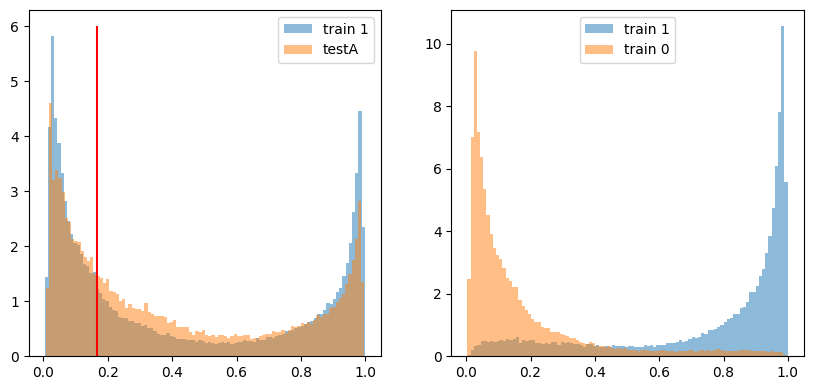

In [18]:
plt.figure(figsize=(10,4.5))
plt.subplot(121)
plt.hist(train_cla_oof, bins=100, alpha=0.5, label='train 1', density=True)
plt.hist(test_cla_pred, bins=100, alpha=0.5, label='testA', density=True)
plt.vlines(thr_optimal, 0, 6, color='r')
plt.legend()

plt.subplot(122)
idx = train_cla_y==1
plt.hist(train_cla_oof[idx], bins=100, alpha=0.5, label='train 1', density=True)
plt.hist(train_cla_oof[~idx], bins=100, alpha=0.5, label='train 0', density=True)
plt.legend()

In [19]:
feat_cla_imp['mean'] = feat_cla_imp[[f"fold_{fold}" for fold in range(cla_model.nfold)]].mean(axis=1)
feat_cla_imp = feat_cla_imp.sort_values(by="mean", ascending=False)
feat_cla_imp.to_csv('model/feats_cla_imp.csv', index=False)

In [20]:
corr_data = all_corr_data(train_cla_x,train_cla_y)
corr_data.to_csv('model/corr_cla.csv')

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


In [21]:
test_cla_pred = (test_cla_pred>=thr_optimal).astype('int')
train_cla_oof = (train_cla_oof>=thr_optimal).astype('int')

In [22]:
reg_params = {
    'objective': 'mape', # multiclass multiclassova
    'metric': 'mape', #  average_precision auc
    'boosting_type': 'gbdt',
    'num_leaves': 16,
    'min_data_in_leaf': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'feature_fraction_seed':SEED,
    'bagging_seed':SEED,
    'seed': SEED,
}
train_base = pd.concat([train_base, train_reg_base], axis=1)
testA_base = pd.concat([testA_base, testA_reg_base], axis=1)

FEATS = [item for item in train_base.columns if item not in ['cust_wid', 'label']]
idx = (train_base[TARGET_COL]>0) & (train_cla_oof>0)
train_reg_x = train_base.loc[idx, FEATS]
train_reg_y = train_base.loc[idx, TARGET_COL]
testA_reg_x = testA_base[FEATS]
print(train_reg_x.shape, train_reg_y.shape, testA_reg_x.shape)

reg_model = cv_model(task_name='reg_lgb', nfold=10)
train_reg_oof, feat_reg_imp = reg_model.fit(reg_params, train_reg_x, train_reg_y, cat_feats=['gdr_cd','cty_cd'])
reg_model.save_model()
reg_model.load_model()
test_reg_pred = reg_model.predict(testA_reg_x)


(38734, 216) (38734,) (50000, 216)


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.630794	valid_1's mape: 0.639902
Early stopping, best iteration is:
[80]	training's mape: 0.633194	valid_1's mape: 0.63968


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.631296	valid_1's mape: 0.640276
[200]	training's mape: 0.620996	valid_1's mape: 0.639696
[300]	training's mape: 0.614408	valid_1's mape: 0.639768
Early stopping, best iteration is:
[209]	training's mape: 0.620159	valid_1's mape: 0.639412


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.630494	valid_1's mape: 0.64212
Early stopping, best iteration is:
[78]	training's mape: 0.633047	valid_1's mape: 0.64173


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.631561	valid_1's mape: 0.64148
[200]	training's mape: 0.621898	valid_1's mape: 0.641672
Early stopping, best iteration is:
[140]	training's mape: 0.627482	valid_1's mape: 0.64126


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.630575	valid_1's mape: 0.639613
[200]	training's mape: 0.620706	valid_1's mape: 0.639849
Early stopping, best iteration is:
[126]	training's mape: 0.62799	valid_1's mape: 0.639442


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.631169	valid_1's mape: 0.642253
[200]	training's mape: 0.621358	valid_1's mape: 0.641785
[300]	training's mape: 0.613415	valid_1's mape: 0.641911
Early stopping, best iteration is:
[214]	training's mape: 0.619974	valid_1's mape: 0.641585


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.63225	valid_1's mape: 0.639194
Early stopping, best iteration is:
[98]	training's mape: 0.632492	valid_1's mape: 0.63913


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.631395	valid_1's mape: 0.641211
Early stopping, best iteration is:
[69]	training's mape: 0.633857	valid_1's mape: 0.641044


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.630491	valid_1's mape: 0.639362
Early stopping, best iteration is:
[83]	training's mape: 0.632417	valid_1's mape: 0.639036


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's mape: 0.630387	valid_1's mape: 0.642283
[200]	training's mape: 0.621123	valid_1's mape: 0.641194
[300]	training's mape: 0.61438	valid_1's mape: 0.641535
Early stopping, best iteration is:
[250]	training's mape: 0.61834	valid_1's mape: 0.640874


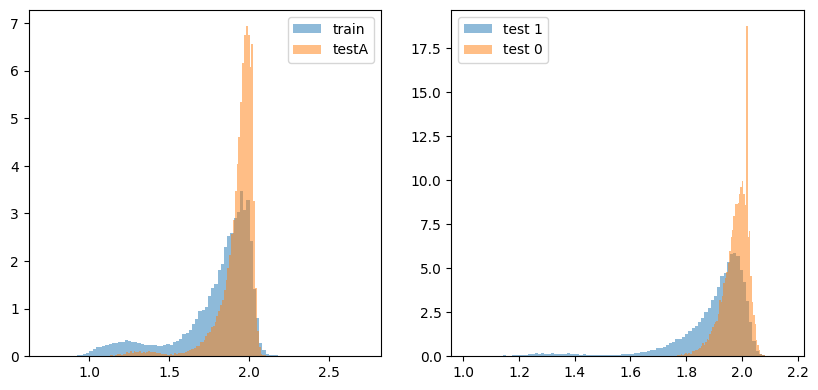

In [23]:
plt.figure(figsize=(10,4.5))

plt.subplot(121)
# plt.hist(train_reg_y, bins=100, alpha=0.5, label='train 1', density=True)
plt.hist(train_reg_oof, bins=100, alpha=0.5, label='train', density=True)
plt.hist(test_reg_pred, bins=100, alpha=0.5, label='testA', density=True)
plt.legend()

plt.subplot(122)
idx = test_cla_pred == 1
plt.hist(test_reg_pred[idx], bins=100, alpha=0.5, label='test 1', density=True)
plt.hist(test_reg_pred[~idx], bins=100, alpha=0.5, label='test 0', density=True)
plt.legend()

In [24]:
feat_reg_imp['mean'] = feat_reg_imp[[f"fold_{fold}" for fold in range(reg_model.nfold)]].mean(axis=1)
feat_reg_imp = feat_reg_imp.sort_values(by="mean", ascending=False)
feat_reg_imp.to_csv('model/feats_reg_imp.csv', index=False)

In [25]:
test_reg_pred = test_reg_pred.round(0).astype('int')
train_reg_oof = train_reg_oof.round(0).astype('int')

In [26]:
Counter(test_reg_pred)

Counter({2: 48743, 1: 1257})

In [27]:
train_reg_oof.shape

(38734,)

In [28]:
test_pred = pd.DataFrame({'cust_wid': testA_base['cust_wid'], 'label': test_cla_pred})
train_oof = pd.DataFrame({'cust_wid': train_base['cust_wid'], 'pred': train_cla_oof, 'true': train_base['label']})

idx = test_pred.label == 1
test_pred.loc[idx, 'label'] = test_reg_pred[idx]

# idx = train_oof.pred == 1
# train_oof.loc[idx, 'pred'] = train_reg_oof

In [29]:
score1 = fbeta_score((train_oof['true']>0).astype('int'), (train_oof['pred']>0).astype('int'), beta=2)
score2 = mean_absolute_percentage_error(train_reg_y, train_reg_oof)
score = score1-0.2*score2
score, score1, score2

(0.7377930889915425, 0.8656764452152458, 0.6394167811185161)

In [30]:
test_pred.label.value_counts()

2    29586
0    19157
1     1257
Name: label, dtype: int64

In [31]:
test_pred.to_csv('output.csv', index=False)